This notebook illustrates the basic usage of ThermoLIB to construct a 1D free energy profile from umbrella sampling simulations using the WHAM methodology, including error estimation from the theory of the maximum likelihood estimator (MLE).

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import BaseFreeEnergyProfile, SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader

import numpy as np, matplotlib.pyplot as pp

from molmod.units import *

Define some file/path variables

In [3]:
prefix = 'basic_wham1d_' #will be added to all figures made in this notebook
fn_meta = 'data/formic_acid_dimer/wham_input.txt' #location of the plumed metadata file containing all information of the umbrella sampling

# Basic WHAM application

First read the input trajectories and define the corresponding bias potentials of each biased simulations included in the metadata file. This is done using the ``read_wham_input`` routine in the code block below. Assuming a metadata file with lines in the form of:

    u80  0.38976377952755903   3500.0

we interpret the metadata file using the keywords of the ``read_wham_input`` routine below as follows. A simulation was done with a bias potential of type ``'Parabola1D'`` with ``Q0 = 0.38976`` and ``kappa = 3500.0`` and was given the label ``u80``. In the code block below, we define the unit of ``Q0`` as ``au`` and that of ``kappa`` as ``kjmol``. Furthermore, the corresponding trajectory of Q values during this simulation is stored in a file with path ``colvars/COLVAR_u80.dat`` relative to the metadata file directory. This file is then read by ``colvar_reader`` which is an instance of ``ColVarReader`` class and assumes the file to be a colvar file that stores the values of Q in column ``0`` of a numpy file in units ``au``. Finally, the temperature is also read from the metadata file from the line (usually the first line) that starts with ``T``.

In [4]:
colvar_reader = ColVarReader([0], units=['au'], verbose=True)
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
    verbose=True
)

Temperature set at 273.000000
Read 10001 trajectory samples for 1 CVs from data/formic_acid_dimer/colvars/COLVAR_u0.dat
Added bias Parabola1D (u0): K=3500 kjmol  q0=-1.500e+00 au
Read 10001 trajectory samples for 1 CVs from data/formic_acid_dimer/colvars/COLVAR_u1.dat
Added bias Parabola1D (u1): K=3500 kjmol  q0=-1.476e+00 au
Read 10001 trajectory samples for 1 CVs from data/formic_acid_dimer/colvars/COLVAR_u2.dat
Added bias Parabola1D (u2): K=3500 kjmol  q0=-1.453e+00 au
Read 10001 trajectory samples for 1 CVs from data/formic_acid_dimer/colvars/COLVAR_u3.dat
Added bias Parabola1D (u3): K=3500 kjmol  q0=-1.429e+00 au
Read 10001 trajectory samples for 1 CVs from data/formic_acid_dimer/colvars/COLVAR_u4.dat
Added bias Parabola1D (u4): K=3500 kjmol  q0=-1.406e+00 au
Read 10001 trajectory samples for 1 CVs from data/formic_acid_dimer/colvars/COLVAR_u5.dat
Added bias Parabola1D (u5): K=3500 kjmol  q0=-1.382e+00 au
Read 10001 trajectory samples for 1 CVs from data/formic_acid_dimer/colvars/

The output for the ``read_wham_input`` routine shows (at least if the keyword ``verbose`` is set to ``True``) for each simulation from which file the CV data is read, how many samples are in that simulation as well as which bias potential is used. Next, we construct the 1D probability histogram on the given grid (defined by ``bins``) using the WHAM routine.

In [5]:
bins = np.arange(-1.7, 1.7, 0.02)
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, Nscf=10000, verbosity='medium')

Initialization ...
Constructing individual histograms for each biased simulation ...
Computing bias on grid ...
Solving WHAM equations (SCF loop) ...
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.068s
  bias poten. : 00h 00m 00.015s
  solve scf   : 00h 00m 00.323s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.407s
---------------------------------------------------------------------


From the histogram, we can construct the corresponding free energy profile. We assume the profile contains a single transition state maximum within the Q-range of ``[-0.2,0.2]``, and a reactant state minimum for lower Q value and product state minimum for higher Q value. This is encoded in the class ``SimpleFreeEnergyProfile``. We then also define the energy reference by setting the reactant state minimum to zero and plot the resulting profile.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


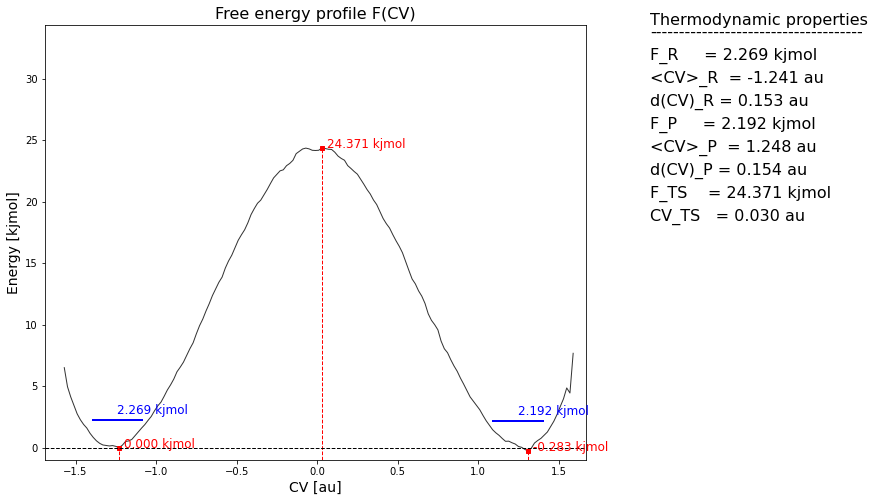

In [6]:
fep = SimpleFreeEnergyProfile.from_histogram(hist, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep.set_ref(ref='r')
fep.plot(prefix+'fep.png')

# WHAM with error estimation

Using the same simulation data (and bias potentials) of the previous section, we repeat the WHAM histogram construction and corresponding free energy profile derivation, but now with error estimation. Such error estimation can be done in distinct ways using the theory of Maximum Likelihood Estimators (MLE): `mfe_f` and `mle_p` both use the theory of the Fisher information matrix to compute the error on an MLE, but the first computes the error on the MLE of the free energy directly (and assumes it to be Normally distributed, resulting in an error on the probability to be LogNormally distributed), while the second computes the error on the MLE of the probability (and assumes it to be normally distributed) and then transforms it to an error on the free energy. In general the `mle_f` method is more accurate as it takes explicitly into account that the probabilty should be positive, but if the error is overall small, `mle_f` and `mle_p` are equivalent as will be shown below. 

Finally, both methods ca be augmented with the additional suffix `_cov` indicate that not only the diagonal elements of the covariance matrix (i.e. error on each point of fep individually) is accounted for, but also all off-diagonal elements (i.e. the correlation between free energy of different points on the fep). Even though such covariance matrix will not influence the overall error bars on the full profile itself, it will have a big impact in generating samples of the full profile within the estimated error for propagation to the error on derived properties. 

For more information and guidelines on the various schemes of error estimation, we refer to the `advanced_wham1D_error` notebook, here we will only demonstrate the `mle_f_cov` method. In order to estimate the error reliably, we need to first compute the correlation time between the MD steps (see the `advanced_wham1D_error` notebook for more details on this as well), which we then also will need to parse to the from_wham routine for error estimation:

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

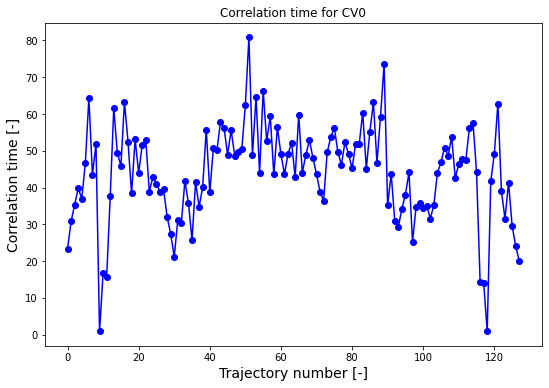

In [7]:
corrtimes = decorrelate(trajectories, fn_plot=prefix+'corrtimes.png')

In [8]:
bins = np.arange(-1.7,1.7, 0.02)
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.073s
  bias poten. : 00h 00m 00.014s
  solve scf   : 00h 00m 00.308s
  error est.  : 00h 00m 00.036s
  TOTAL       : 00h 00m 00.432s
---------------------------------------------------------------------


Derive both corresponding free energy profiles with their error bar and make a comparison plot of various FEPs using `plot_feps`:

<Figure size 432x288 with 0 Axes>

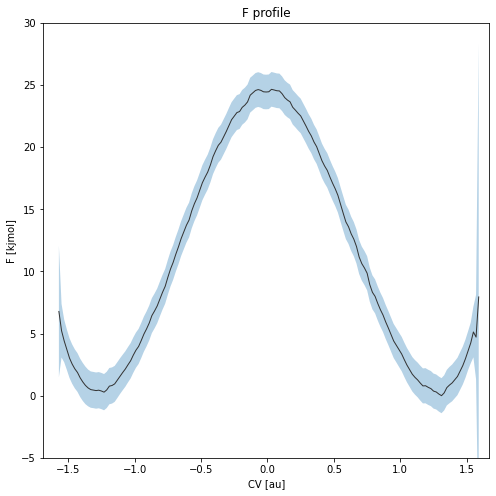

In [9]:
fep = BaseFreeEnergyProfile.from_histogram(hist, temp=temp)
fep.set_ref(ref='min')
fep.plot(prefix+'fep_with_error.png', flims=[-5,30])

One can also plot various samples of the full profile taken according the error estimate:

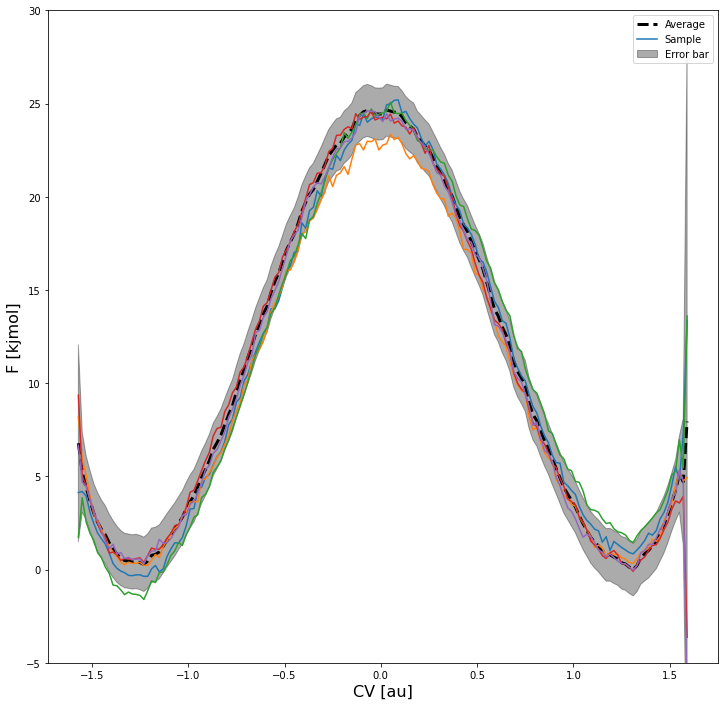

In [10]:
fep.plot_samples(prefix+'fep_samples.png', flims=[-5,30], nsamples=5)

Finally, we can also make a matrix plot of the correlation between the free energy of different points on the fep:

<Figure size 432x288 with 0 Axes>

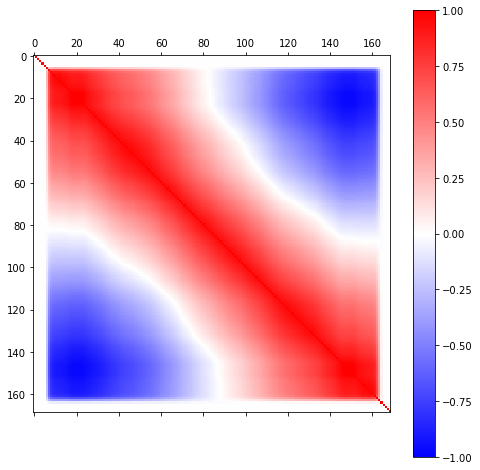

In [11]:
fep.error.plot_corr_matrix(fn=prefix+'fep_corrmatrix.png')

Note that the axis labels are row and column indices of the correlation matrix (for which index=0 corresponds to the lowest CV value and the highest index corresponds to the largest CV value). It is clearly visible from this matrix that each point on the FEP is strongly correlated with its neighbors (elements on and close to diagonal correspond to correlation close to 1.0). Futhermore, we also see that reactant states are strongly anticorrelated to product states (i.e. blue values corresponding to correlation close to -1.0). Finally, both reactant and product states are quasi uncorrelated to the transition state (correlation close to 0.0). All these observations make sense keeping in mind that the free energy is derived from a probability profile that is normalized to 1.

# Free energy profile with macrostates and microstates

In this section, we want to construct a free energy profile (FEP) on which we indicate macro and microstates. In the context of ThermoLIB, a microstate is defined as a single point on the free energy profile, while a macrostate is defined as a region on the free energy profile. The most obvious and usefull examples of both are: a transition state given by the local maximum on a FEP as a microstate, and the reactant/product defined as the region left/right of the transition state as a macrostate. The free energy of a microstate is just simply the corresponding free energy value on the FEP, the free energy of a macrostate is computed through application of boltzmann partition functions as follows:

$F_R = -k_BT\ln\left[\int_{-\infty}^{q^{TST}} e^{-\beta F(q)}dq\right]$

where $q^{TST}$ is the value of the CV in the transition state. In case of a macrostate, it might also be usefull to know the average (and variance) off the CV in the macrostate. 

All of these properties can be computed with ThermoLIB as follows, in which we start from the free energy profile `fep_f` as computed in the previous section. The extraction of the reactant state, transition state and product state for a simple free energy profile with two minima seperated by a single maxima is implemented in the SimpleFreeEnergyProfile class. Therefore, we either need to redo the from_histogram routine but starting from the SimpleFreeEnergyProfile instead of BaseFreeEnergyProfile, i.e. execute::

    fep_f = SimpleFreeEnergyProfile.from_histogram(hist, temp=temp)

Or we simply convert the BaseFreeEnergyProfile to a SimpleFreeEnergyProfile as follows:

In [12]:
fep = SimpleFreeEnergyProfile.from_base(fep)

Now we use ThermoLIB to find the transition state by defining `ts_range` as the range of CV values in which we expect the maximum to be. We also specify an optional argument (cv_lims) in order to limit the overal CV range in all the routines related to finding micro/macrostates. This is usefull whenever the profile has very large error bars on the edges that might give rise to occasional samples in which that edge has a very low free energy (high probability) and hence distort the boltzmann distribution. In the current example this is indeed the case, therefore, we limit the overal CV range to `cv_lims=[-1.5,1.5]`. 

Next, ThermoLIB will automatically defines the reactant/product microstate (as a local minimum left/right of the transition state) as well as the Reactant/Product macrostate (as the integral over all microstates left/right of the transition state):

In [13]:
fep.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 25.044 +- 1.371 kjmol
  CV    = 0.005 +- 0.132 au

MICROSTATE r:
--------------
  index =  None
  F     = 0.173 +- 1.620 kjmol
  CV    = -1.234 +- 0.034 au

MICROSTATE p:
--------------
  index =  None
  F     = 0.046 +- 1.437 kjmol
  CV    = 1.310 +- 0.006 au

MACROSTATE R:
--------------
  F       = 2.682 +- 1.245 kjmol
  CV Mean = -1.231 +- 0.020 au
  CV StD  = 0.146 +- 0.009 au

MACROSTATE P:
--------------
  F       = 2.621 +- 1.334 kjmol
  CV Mean = 1.237 +- 0.019 au
  CV StD  = 0.145 +- 0.009 au



If now plot the free energy profile using the `fep_f.plot(fn)` routine, we will also see the macrostates and microstates indicated:

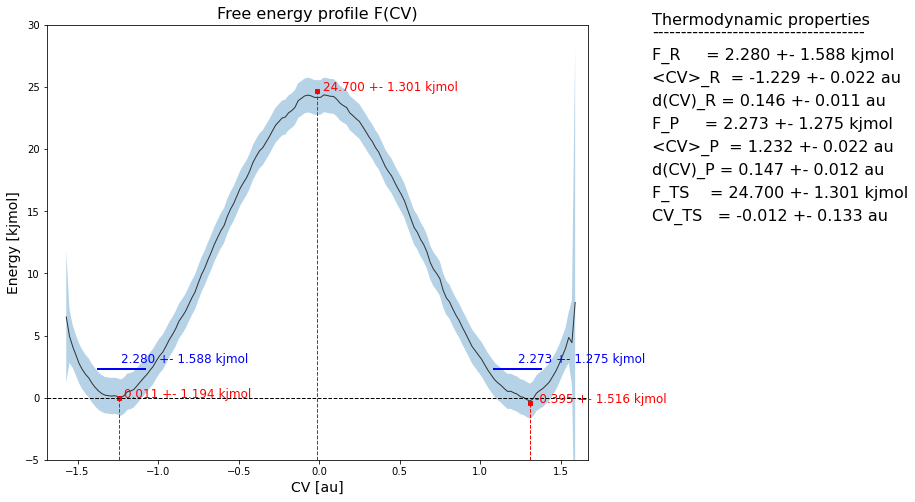

In [14]:
fep.set_ref(ref='r')
fep.plot(prefix+'fep_with_states.png', flims=[-5,30])